In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import io

In [47]:
pwd = os.getcwd()
file201501 = os.path.join(pwd, '2015', 'kody nowe01,15.xls')

#A TRICK TTO NOT GET 5.1 IN COLS NAMES
cols = pd.read_excel(file201501, header=None, nrows=1).values[0]
df201501 = pd.read_excel(file201501, header=None, skiprows=1)
df201501.columns = cols

column_names = list(df201501.columns)
print(column_names)

[nan, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 24, 25, 26, 27, 5, 6, 12, 13, 19, 20, 26, 27, 28, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'SUMA', nan, 'CENA NETTO']


##### wyciagniecie nazw i sum sprzedaży mięsa i wędlin

In [48]:
column = ['SUMA']
summary_df = pd.DataFrame(df201501.iloc[0:50, 41])
change = list(summary_df.columns)
change[0] = 'TOWAR'
summary_df.columns = change
summary_df = summary_df.merge(df201501.loc[0:49, column], left_index=True, right_index=True)
summary_df.head()

,TOWAR,SUMA
0,1. SCHAB Z KOŚCIĄ,181.920
1,2. SCHAB BEZ KOŚCI,192.732
2,3. KARCZEK BEZ KOŚCI,156.977
3,4. SZYNKA Z KOŚCIA,0.000
4,5. SZYNKA BEZ KOŚCI,177.450


##### TABELA ZE SPRZEDAZA Z POSZCZEGLNYCH DNI

In [49]:
sprzedaz = pd.DataFrame(df201501.iloc[0:50, 38])
change1 = list(sprzedaz.columns)
change1[0] = 'TOWAR'
sprzedaz.columns = change

sprzedaz = sprzedaz.merge(pd.DataFrame(df201501.iloc[0:50, 1:29]), left_index=True, right_index=True)
sprzedaz.head()


,TOWAR,3,4,5,6,7,10,11,12,13,...,27,5,6,12,13,19,20,26,27,28
0,1. SCHAB Z KOŚCIĄ,1.978,7.48,3.64,3.31,15.33,10.49,13.71,4.36,0.00,...,0.00,8.10,7.45,8.56,4.70,6.570,1.59,7.74,4.94,16.17
1,2. SCHAB BEZ KOŚCI,5.200,10.56,3.79,1.02,6.2,7.57,6.00,2.92,1.45,...,0.72,6.10,4.60,9.26,36.15,8.732,1.59,3.44,3.56,15.87
2,3. KARCZEK BEZ KOŚCI,6.110,2.34,3.65,0.70,6.57,8.45,8.90,0.00,3.98,...,0.96,6.35,8.10,3.10,7.65,2.610,2.10,4.71,5.29,15.69
3,4. SZYNKA Z KOŚCIA,0.000,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.00,0.00
4,5. SZYNKA BEZ KOŚCI,3.020,65.10,0.00,2.10,15.1,8.31,7.58,2.74,1.02,...,0.00,2.58,1.07,7.07,3.55,2.680,1.18,8.12,1.13,7.30


#### FUNCKJA SUMUJACA ZDUBLOWANE KOLUMNY CZYLI KILKA KAS FISKALNYCH JEDNEGO DNIA

In [50]:
def sumuj_kasy(df) -> pd.DataFrame:
    hist_kolumn = df.columns.value_counts()
    zduplikowane_kolumny = hist_kolumn[hist_kolumn > 1].index.tolist()
    print(zduplikowane_kolumny)
    df_with_deleted_duplicate_columns = df.drop(columns = [int(col) for col in zduplikowane_kolumny])
    
    for col_name in zduplikowane_kolumny:
        indexes = [i for i, col in enumerate(df.columns) if col == col_name]
        
        dup_col1 = df.iloc[:, indexes[0]]
        dup_col2 = df.iloc[:, indexes[1]]
        dup_col1 = dup_col1.add(dup_col2)
        
        df_with_deleted_duplicate_columns[col_name] = dup_col1
            
    return df_with_deleted_duplicate_columns

##### modelowanie df sprzedaz, przygotowanie na wykres, sort kolumn i strip nazw produktow

In [51]:
def clean_products_names(series):
    def clean_record(record):
        new = ''.join([sign for sign in record if sign != '.' and not sign.isdigit()])
        return new.lstrip()
    return series.apply(clean_record)

In [52]:
sprzedaz1 = sprzedaz.copy()

col_poducts = clean_products_names(sprzedaz1['TOWAR'])

sprzedaz_zsumowane_kasy = sumuj_kasy(sprzedaz1)

tmp = sprzedaz_zsumowane_kasy.drop(columns={'TOWAR'})
sprzedaz_zsumowane_kasy1 = tmp.sort_index(axis=1)

#sprzedaz_zsumowane_kasy1['TOWAR'] = col_poducts

sprzedaz_zsumowane_kasy1.loc[34, 7] = 1.28

sprzedaz_zsumowane_kasy1.head() #TOWAR MA INDEX 20


[19, 27, 5, 6, 26, 12, 13, 20]


,3,4,5,6,7,10,11,12,13,14,17,18,19,20,21,24,25,26,27,28
0,1.978,7.48,11.74,10.76,15.33,10.49,13.71,12.92,4.70,15.13,5.23,6.90,6.570,3.54,19.750,0.00,6.45,10.110,4.94,16.17
1,5.200,10.56,9.89,5.62,6.2,7.57,6.00,12.18,37.60,8.22,3.48,1.92,9.102,3.22,22.710,20.24,3.30,4.770,4.28,15.87
2,6.110,2.34,10.00,8.80,6.57,8.45,8.90,3.10,11.63,12.62,4.91,2.76,3.500,5.26,22.324,11.22,5.48,7.173,6.25,15.69
3,0.000,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.00,0.000,0.00,0.00,0.000,0.00,0.00
4,3.020,65.10,2.58,3.17,15.1,8.31,7.58,9.81,4.57,3.10,3.52,5.73,4.830,1.18,9.210,5.06,12.05,8.120,1.13,7.30


#### funckja do wyciagania nazwy dnia z daty

In [53]:
def date_to_day_name(day_num) -> str:
    data_m_y = "2015-01"
    date = data_m_y + "-" + str(day_num)
    
    tmp_dict = {
        "dates" : [date]
    }
    #print(date)
    
    tmp_df = pd.DataFrame(tmp_dict)
    
    tmp_df["dates"] = pd.to_datetime(tmp_df["dates"])    

    tmp_df["day_name"] = tmp_df["dates"].dt.day_name()
    
    return tmp_df.loc[0, "day_name"]
    
print(date_to_day_name(23))

Friday


#### Projektowanie wykresu sprzedazy i generowanie wszystkich

C:\Users\damia\AppData\Local\Temp\ipykernel_3052\705395875.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plot_list.append(plt.figure())


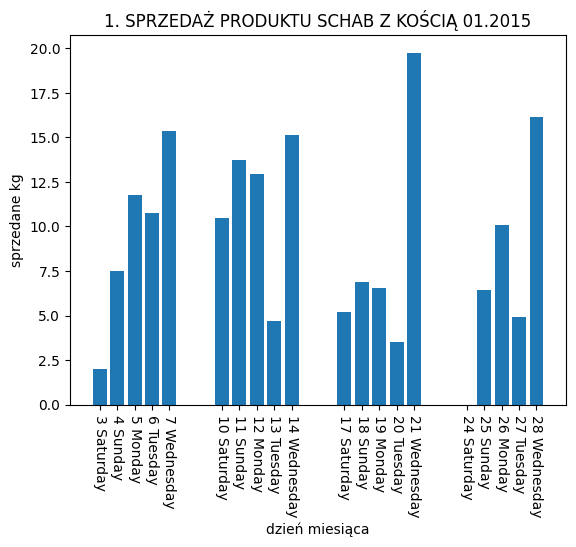

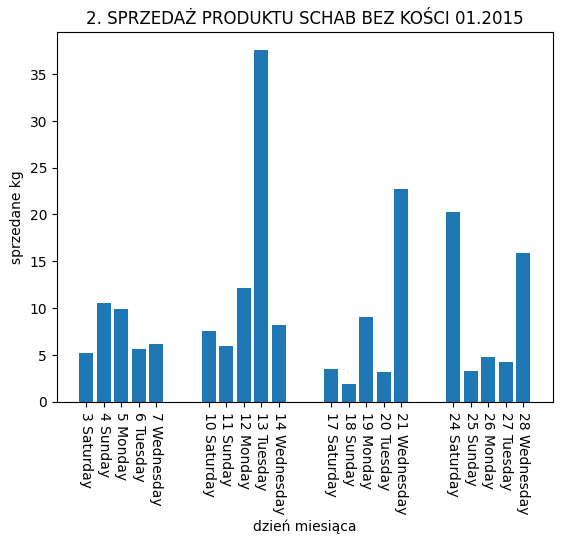

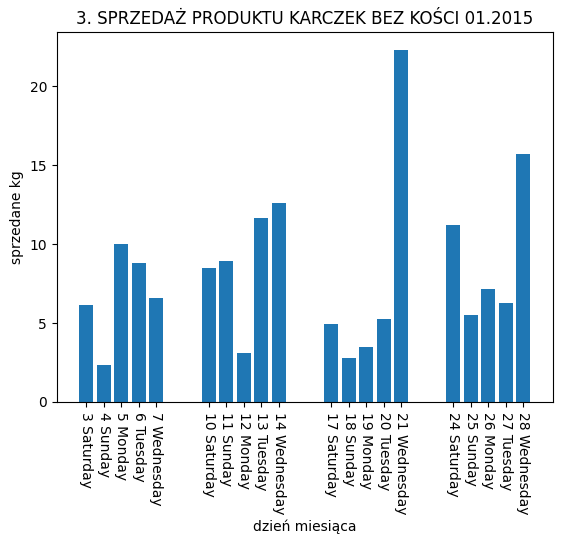

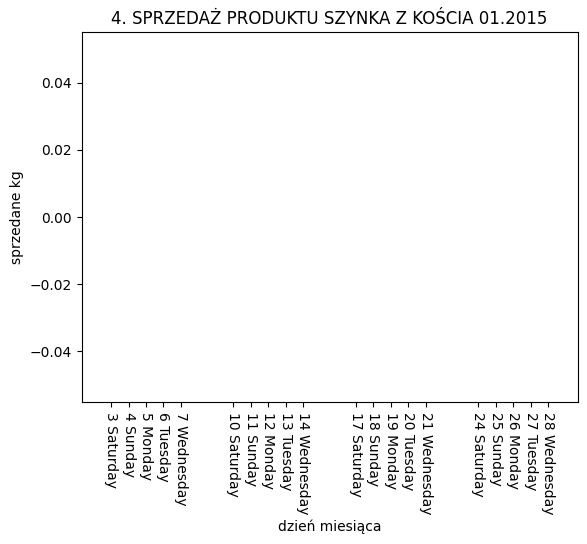

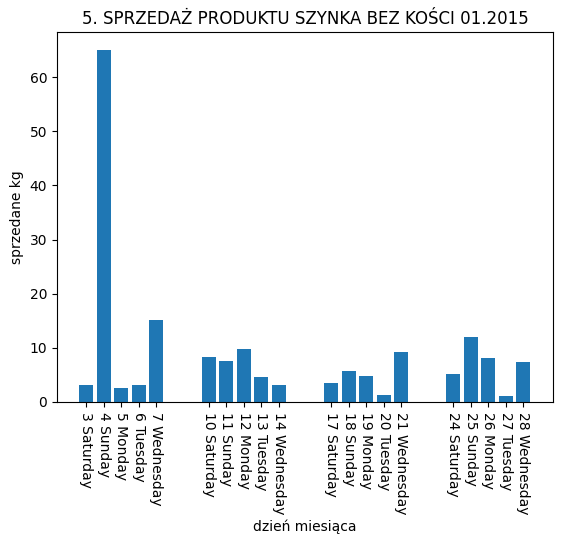

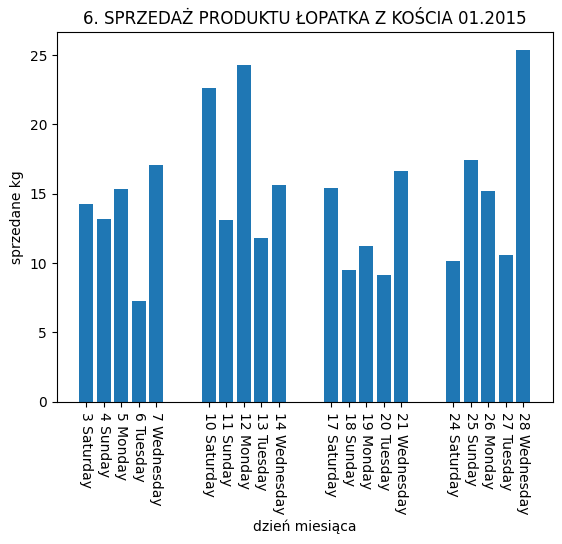

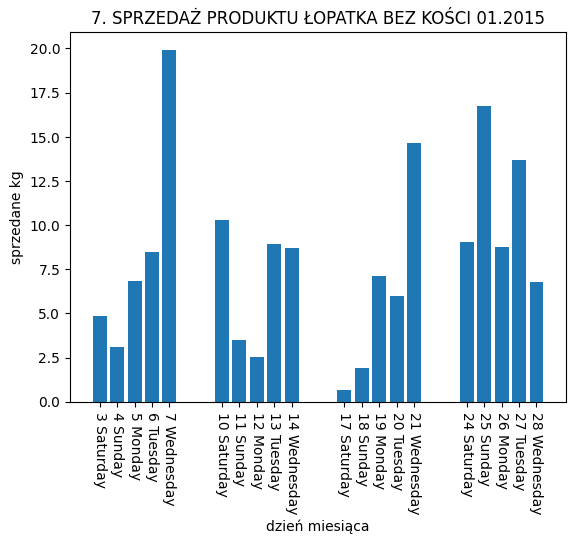

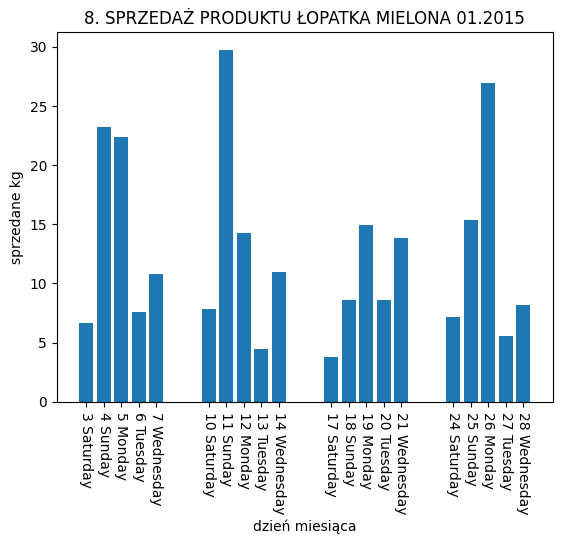

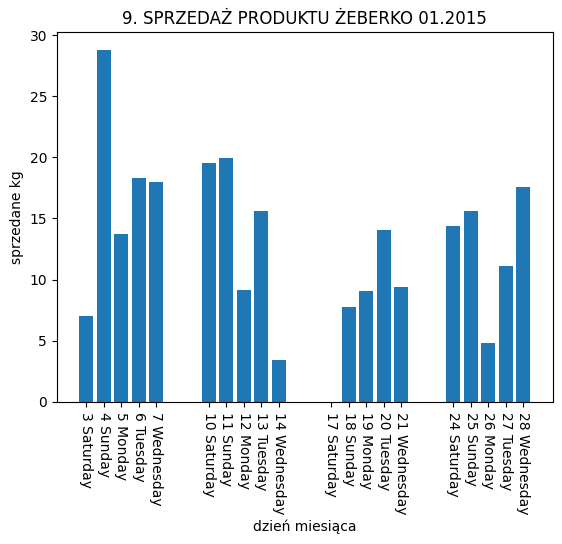

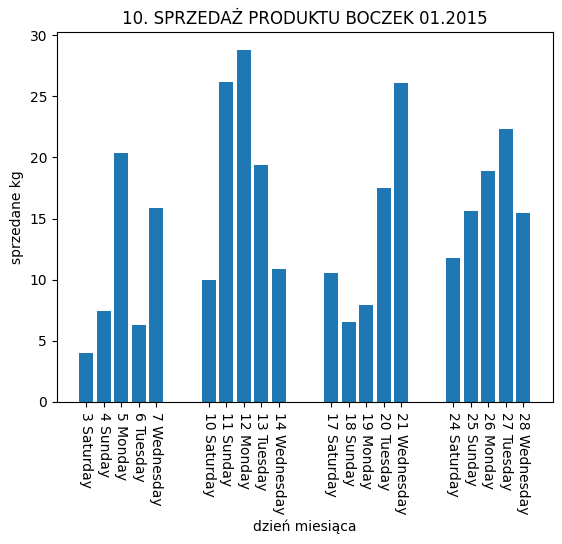

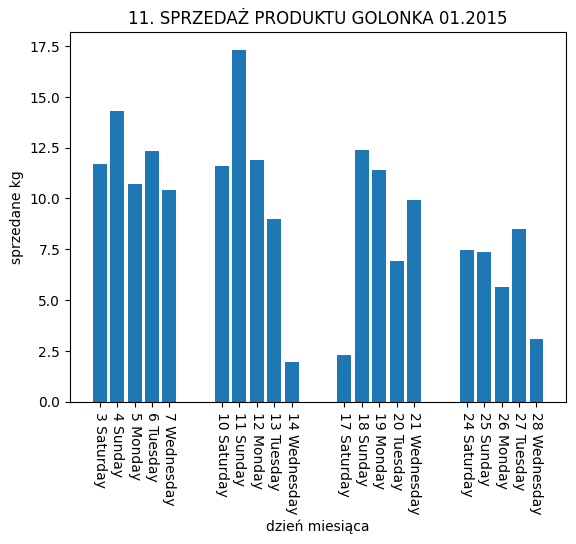

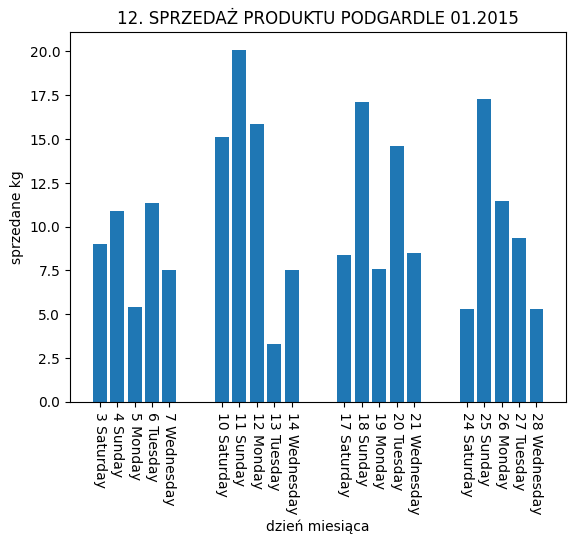

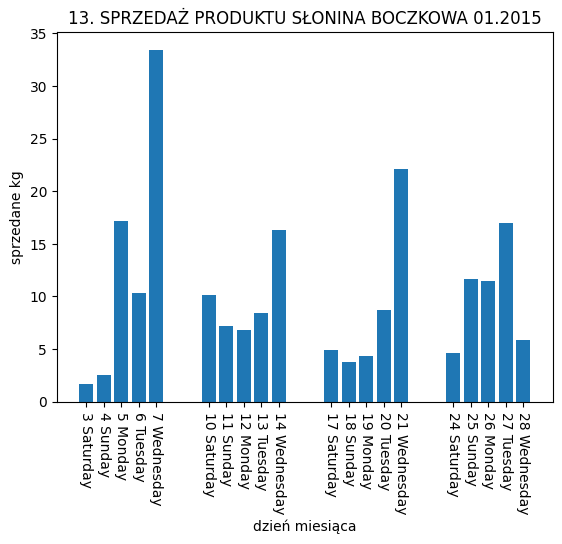

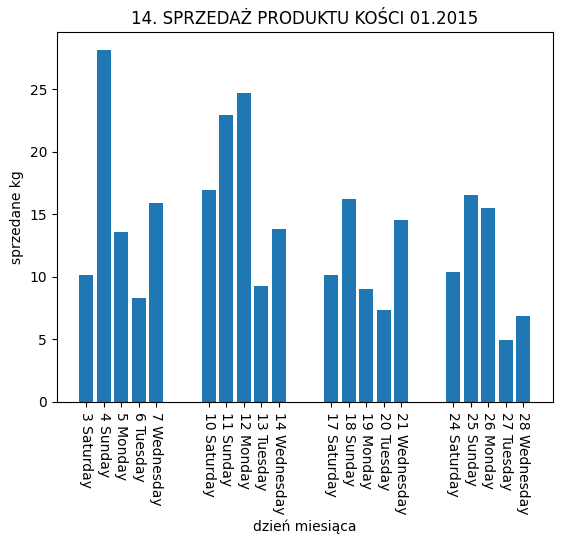

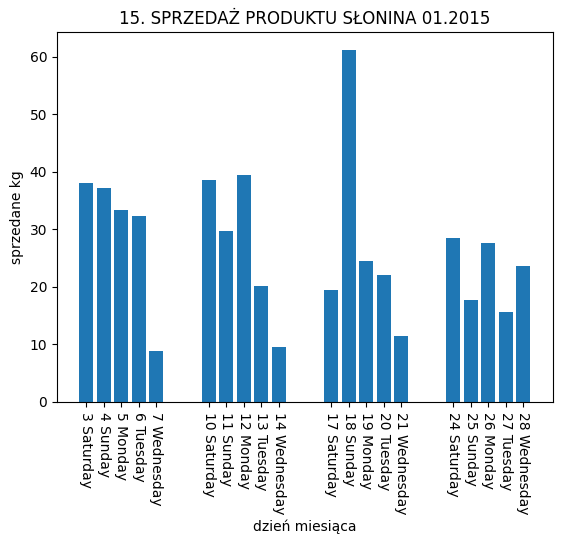

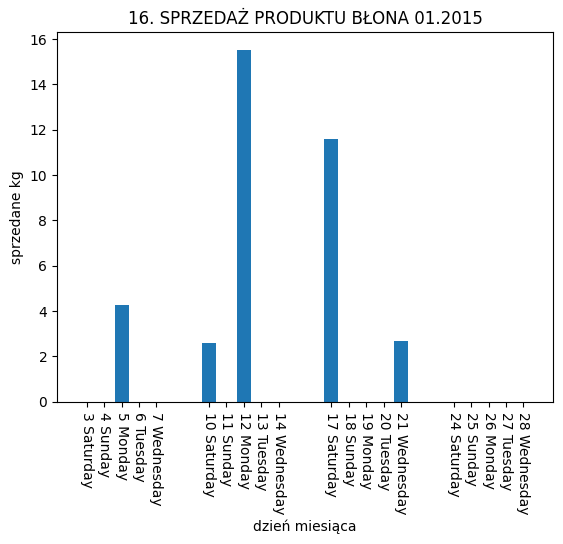

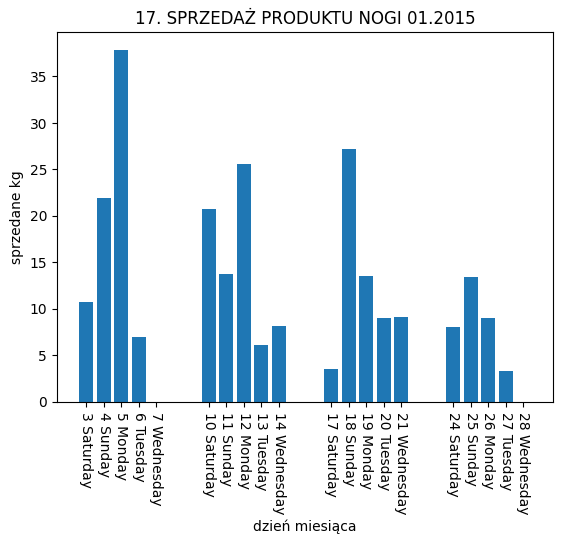

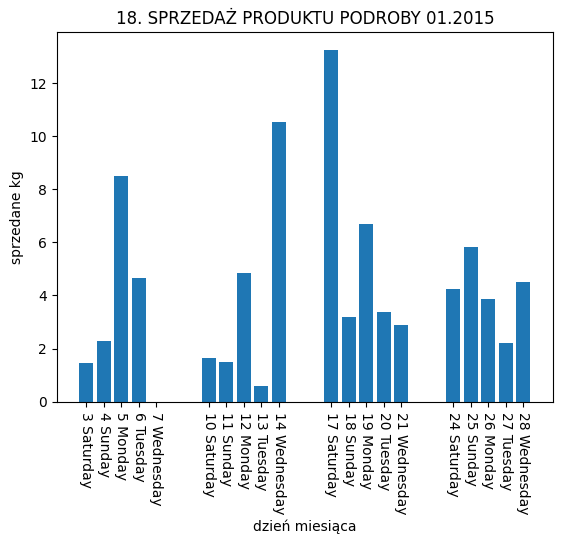

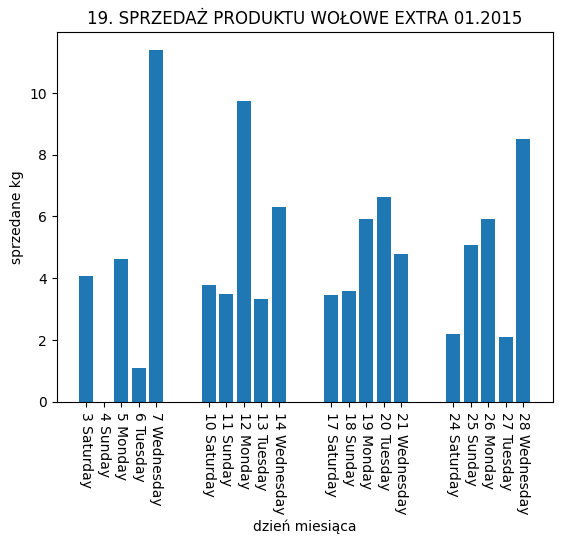

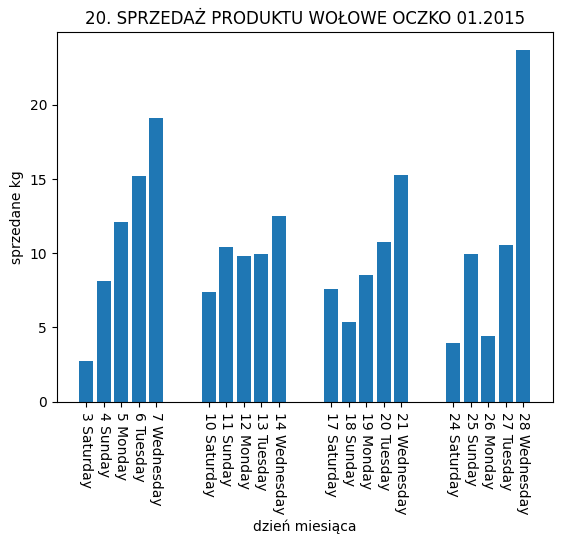

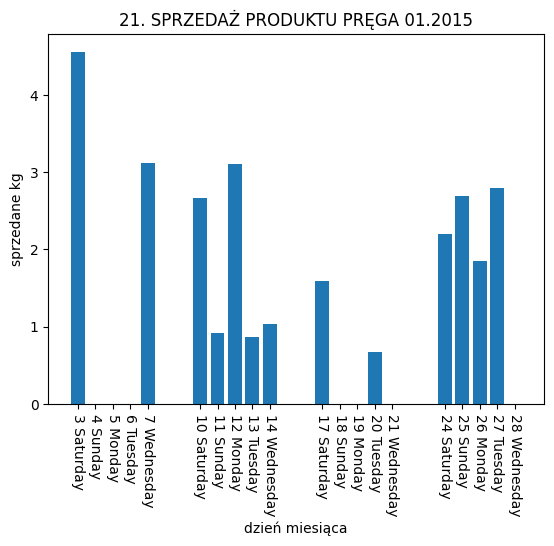

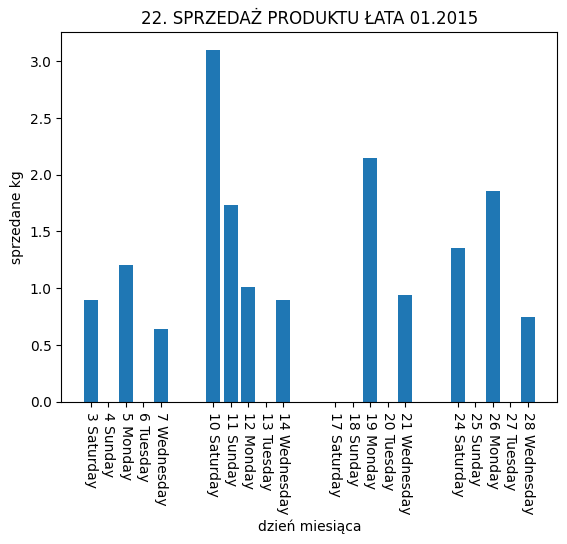

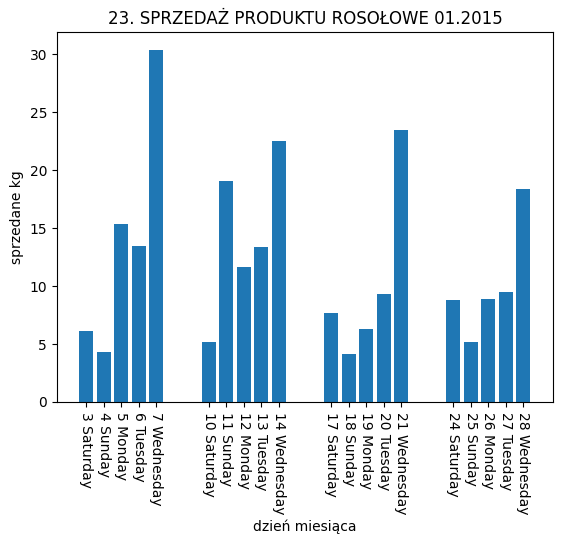

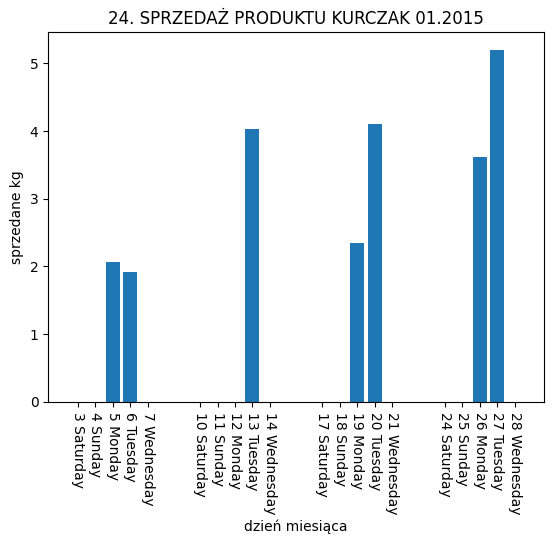

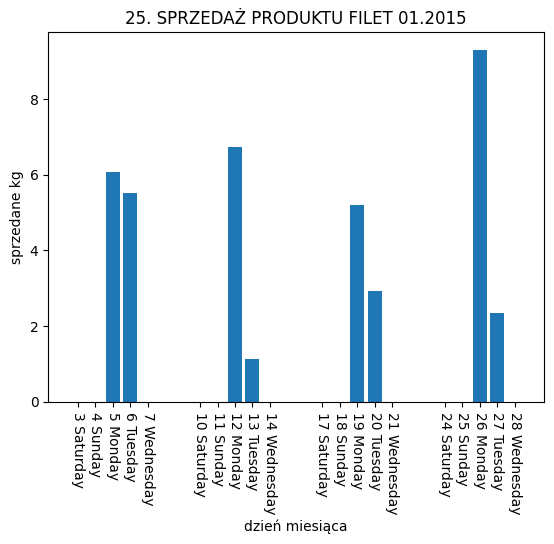

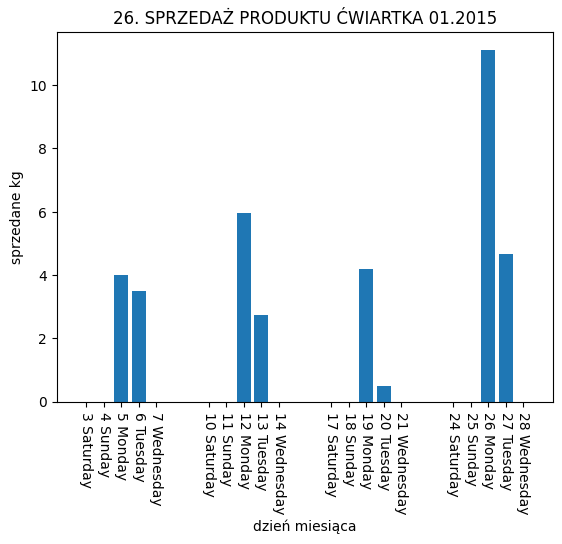

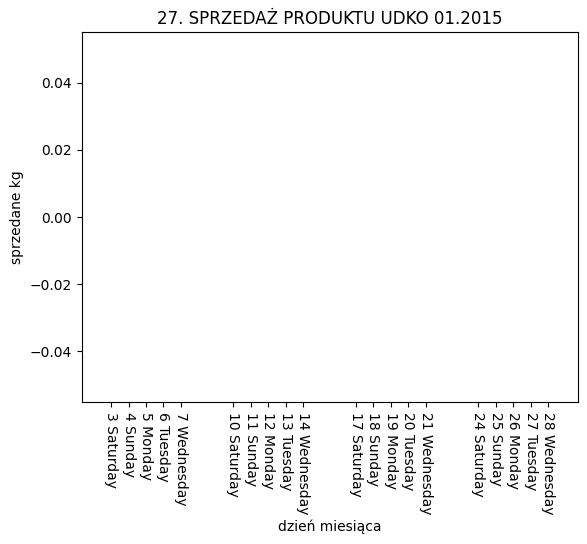

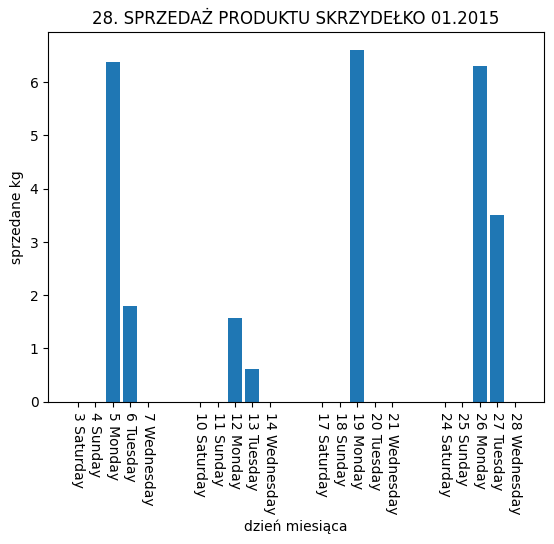

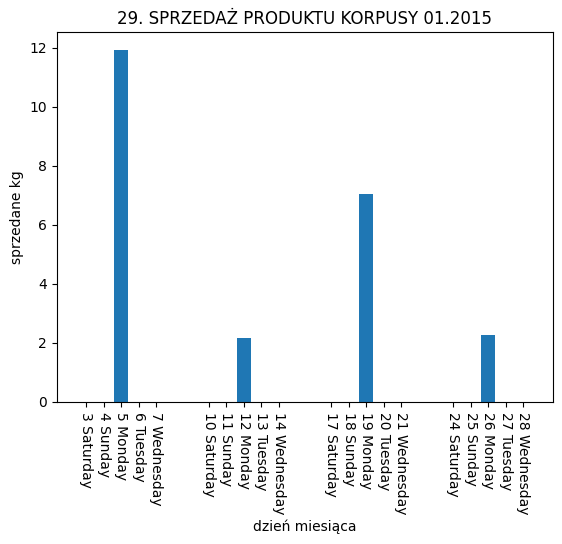

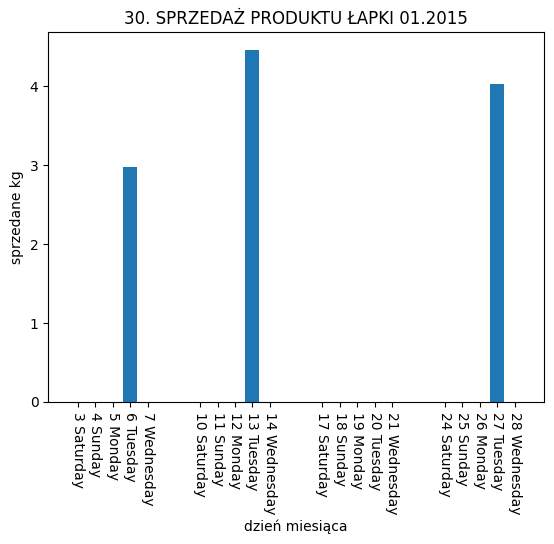

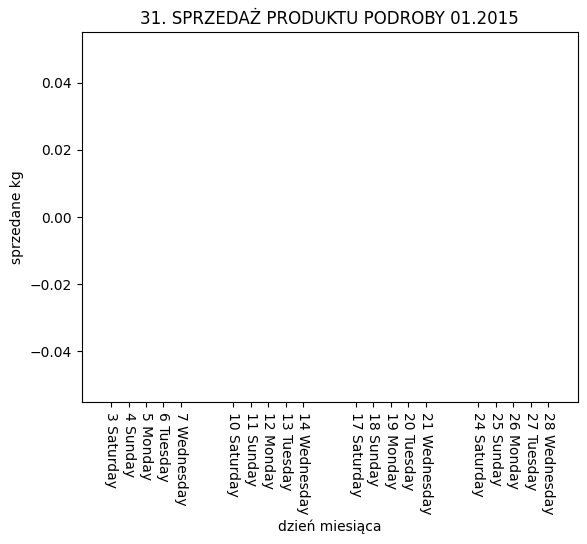

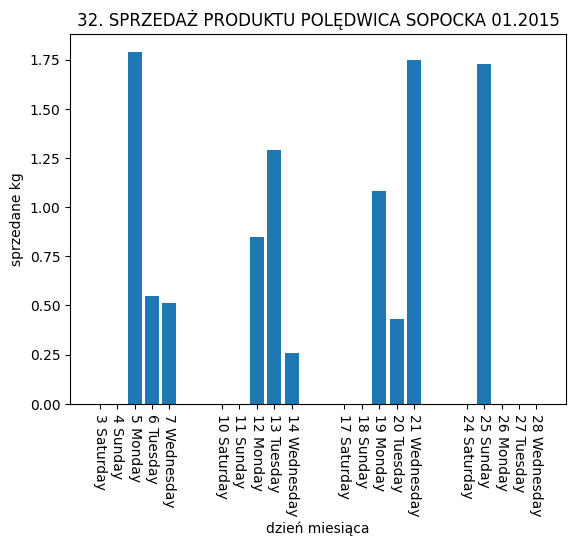

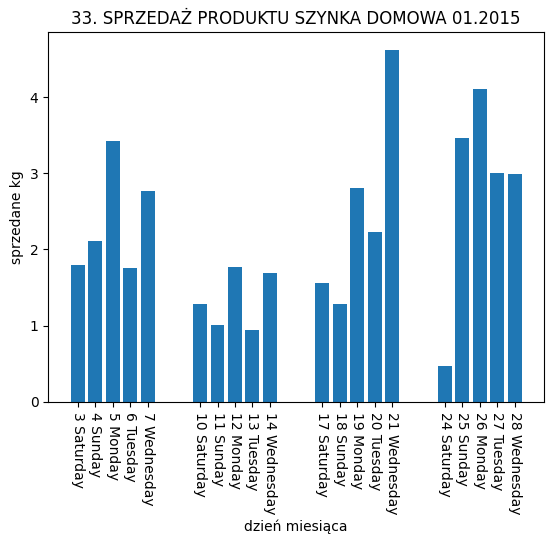

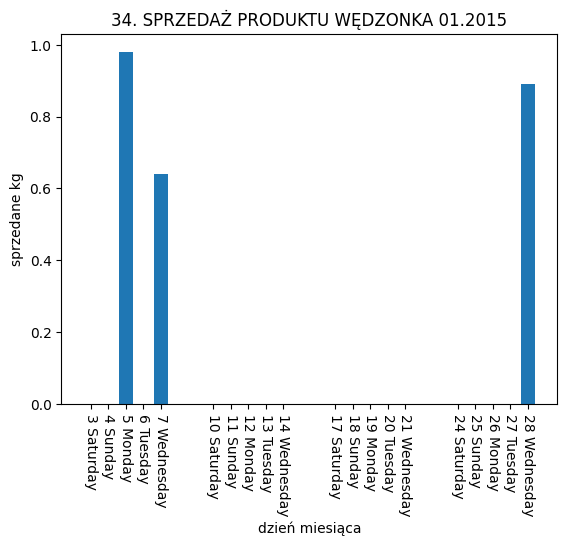

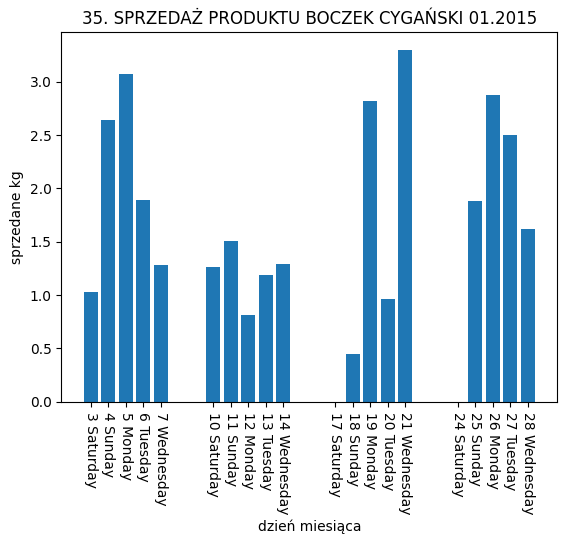

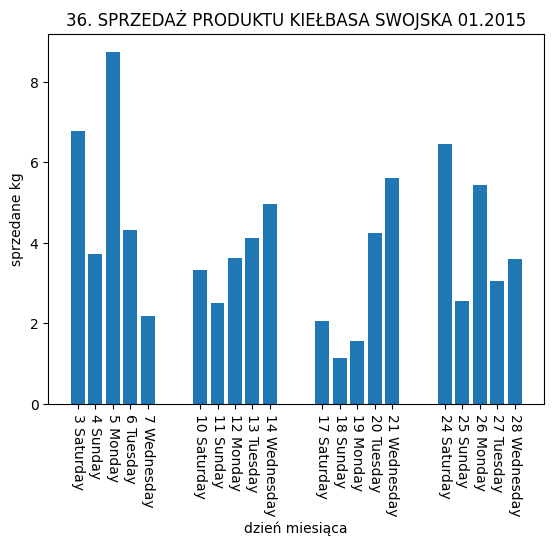

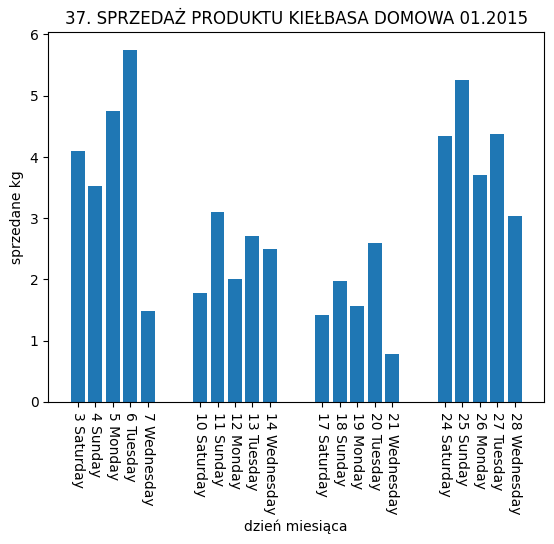

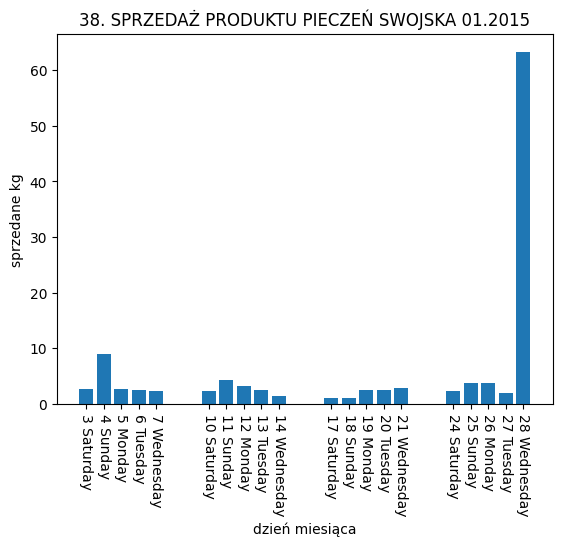

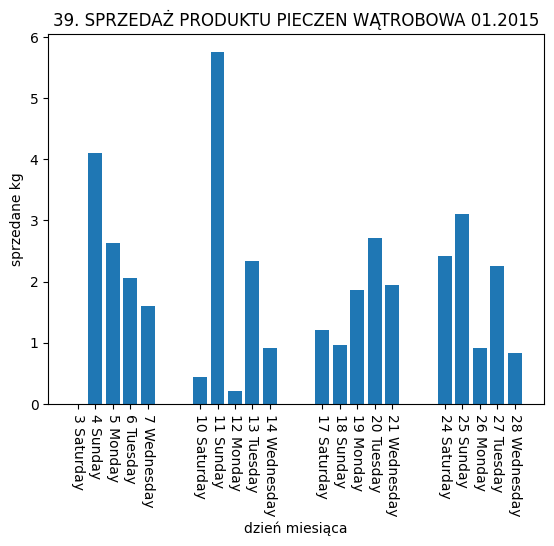

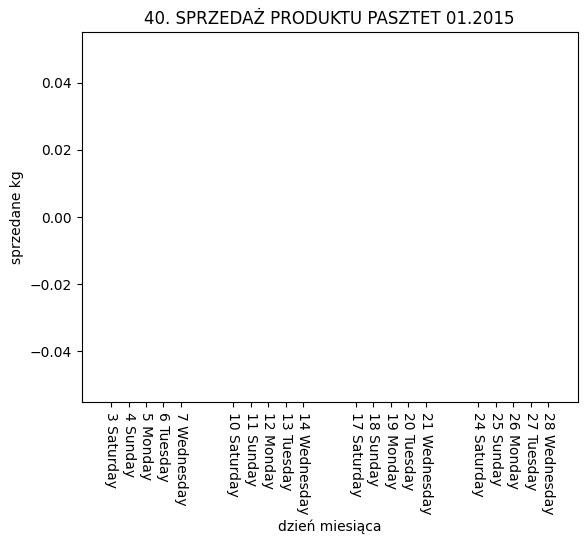

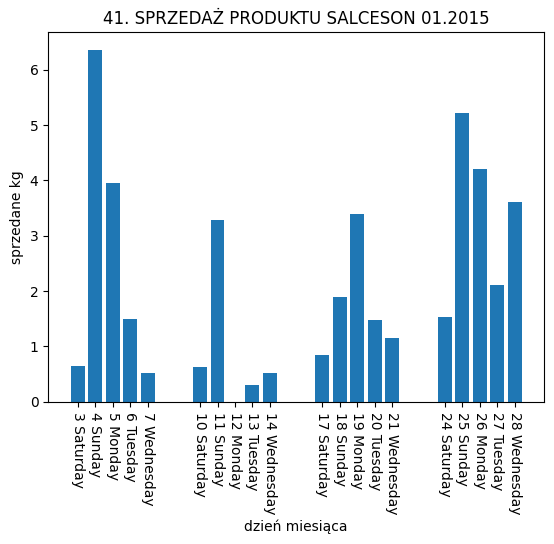

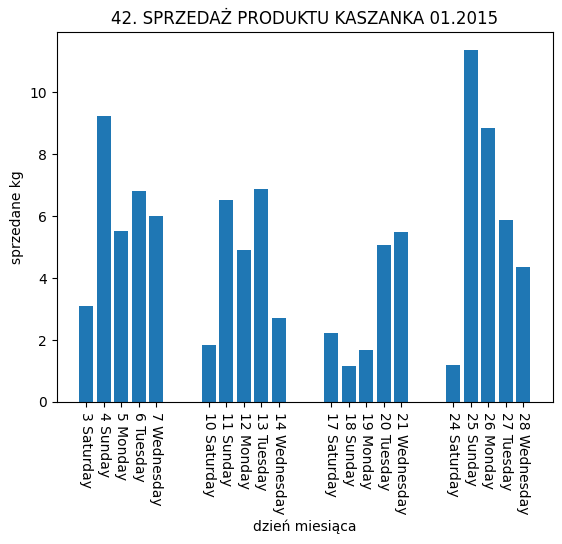

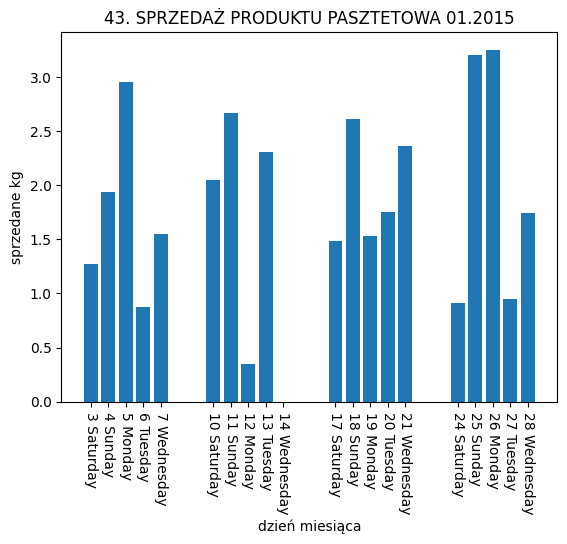

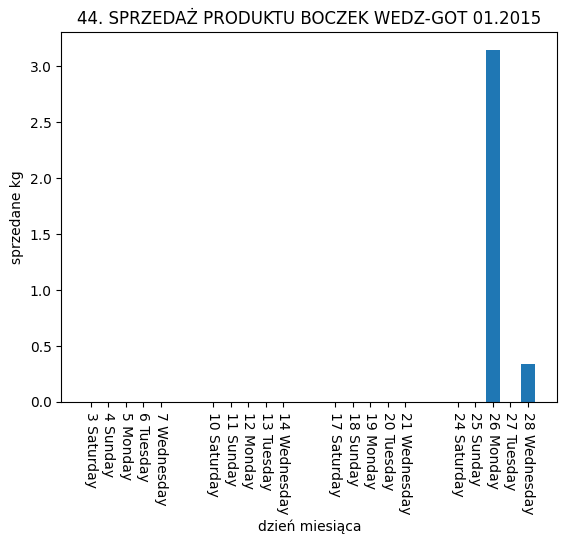

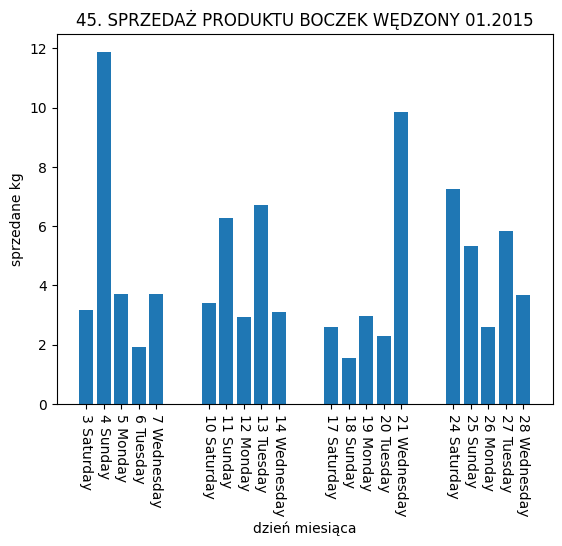

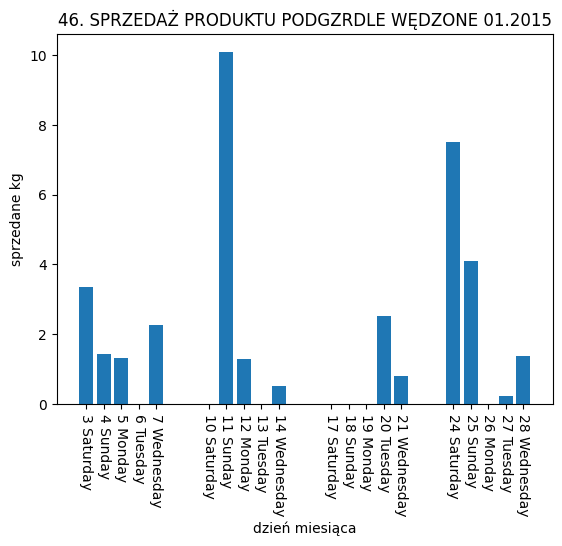

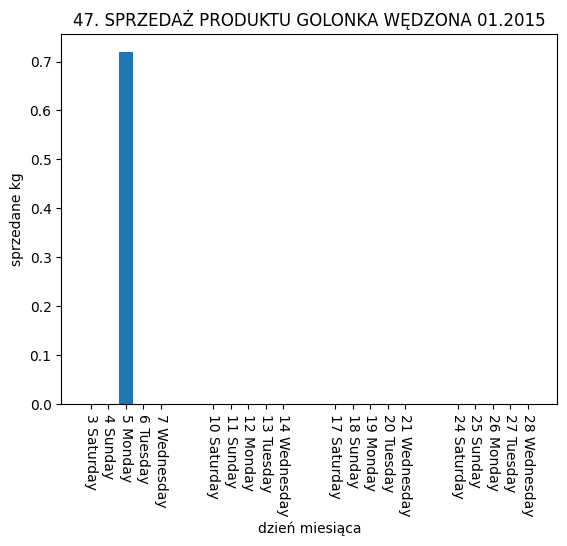

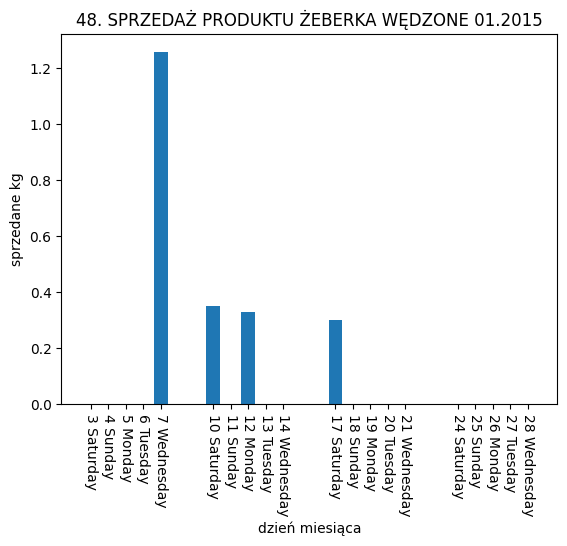

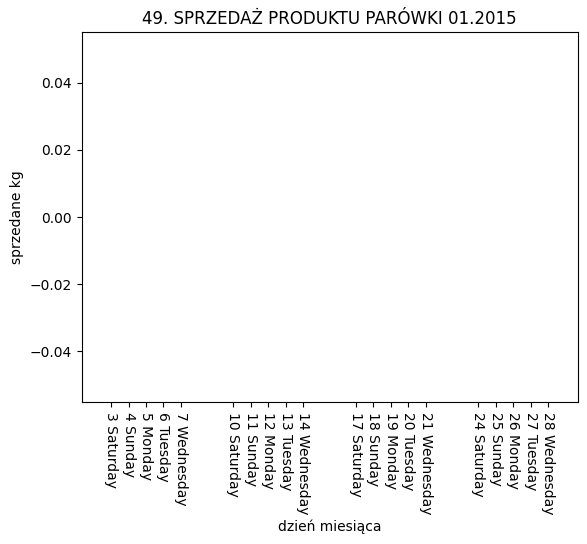

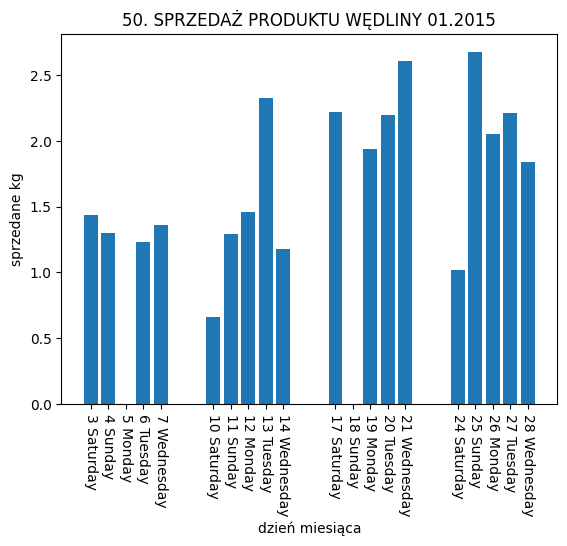

In [56]:
data_date = "01.2015"
plot_list= []

x = sprzedaz_zsumowane_kasy1.columns
list_for_x_ticks = [i for i in sprzedaz_zsumowane_kasy1.columns]
list_with_day_names = []

for date in list_for_x_ticks:
    list_with_day_names.append(str(date) + " " + date_to_day_name(date))
 

for i in range(sprzedaz_zsumowane_kasy1.shape[0]):
    y = sprzedaz_zsumowane_kasy1.iloc[i].values

    plot_list.append(plt.figure())
    plt.bar(x, y)
    plt.title(str(i + 1) + ". " + "SPRZEDAŻ PRODUKTU " + col_poducts[i] + " " + data_date)

    plt.xticks(ticks = list_for_x_ticks, labels = list_with_day_names, rotation = 270) ## here to have days
    plt.ylabel('sprzedane kg')
    plt.xlabel('dzień miesiąca')

    
    


#### Generowanie pliku z wykresami

In [55]:
with PdfPages("test plots and analitycs/wykesy_sprzedazy_01_2015.pdf") as pdf:
    
    num_plots = len(plot_list)
    plots_per_page = 3
    rows_per_page = 3
    
    idx = 0
    
    for i in range(0, num_plots, plots_per_page * rows_per_page):
        fig, axs = plt.subplots(rows_per_page, plots_per_page, figsize=(20, 15))
        fig.tight_layout(pad=0.5)
        
        axs = axs.flatten()
        
        for sub in range(plots_per_page * rows_per_page)
            if i + sub < num_plots:
                plot = plot_list[idx]
                
                buf = io.BytesIO()
                plot.savefig(buf, format='png')
                buf.seek(0)
                
                axs[sub].imshow(plt.imread(buf))
                axs[sub].axis('off')
                plt.close(plot)
            else:
                fig.delaxes(axs[sub])
            idx += 1
                
        pdf.savefig(fig)
        plt.close(fig)